In [1]:
import  numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
tfk  = tf .keras
tfkl = tfk.layers

from sklearn.datasets import make_moons, make_classification
from tqdm import tqdm

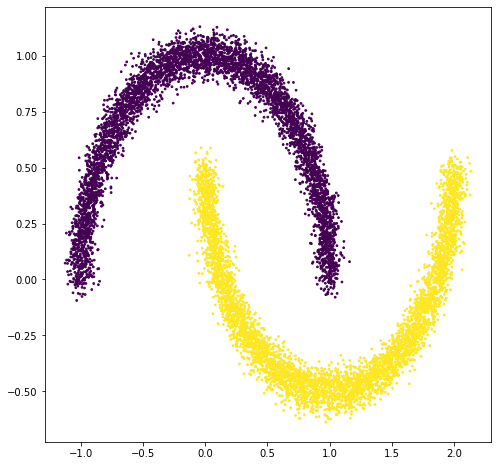

In [2]:
X, Y = make_moons(n_samples = 10000, noise = 0.05)
plt.figure(figsize = (8, 8))
plt.scatter(
    X[:, 0],
    X[:, 1],
    c = Y,
    cmap = 'viridis',
    s = 3,
)
plt.show()

In [3]:
clf = tfk.Sequential([
    tfkl.InputLayer(2),
    tfkl.Dense(20),
    tfkl.BatchNormalization(),
    tfkl.Lambda(tf.nn.relu),
    tfkl.Dense(20),
    tfkl.BatchNormalization(),
    tfkl.Lambda(tf.nn.relu),
    tfkl.Dense(1, activation = 'sigmoid')
])
clf.compile(
    loss = 'binary_crossentropy',
    metrics = [tfk.metrics.AUC()],
    optimizer = 'adam'
)
idxs = np.arange(len(X))
np.random.shuffle(idxs)
split = int(0.75 * len(X))
X_train, X_test, Y_train, Y_test = X[:split], X[split:], Y[:split], Y[split:]
hist = clf.fit(
    X_train, Y_train,
    epochs = 5,
    batch_size = 64,
    validation_split = 0.33
)
res = clf.evaluate(X_test, Y_test)

2021-11-22 23:48:04.598486: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-22 23:48:04.608084: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-22 23:48:04.608844: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-22 23:48:04.609613: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Epoch 1/5
79/79 [==============================] - 1s 5ms/step - loss: 0.3719 - auc: 0.9382 - val_loss: 0.4838 - val_auc: 0.9835
Epoch 2/5
79/79 [==============================] - 0s 3ms/step - loss: 0.1500 - auc: 0.9972 - val_loss: 0.3819 - val_auc: 0.9834
Epoch 3/5
79/79 [==============================] - 0s 3ms/step - loss: 0.0899 - auc: 0.9995 - val_loss: 0.2848 - val_auc: 0.9851
Epoch 4/5
79/79 [==============================] - 0s 3ms/step - loss: 0.0560 - auc: 0.9999 - val_loss: 0.1787 - val_auc: 0.9985
Epoch 5/5
79/79 [==============================] - 0s 1ms/step - loss: 0.0775 - auc: 1.0000


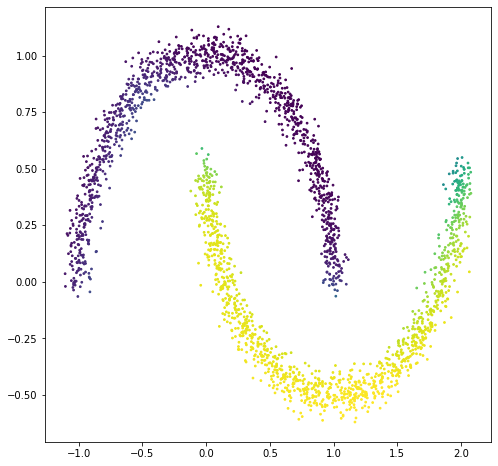

In [4]:
plt.figure(figsize = (8, 8))
plt.scatter(
    X_test[:, 0],
    X_test[:, 1],
    c = clf(X_test).numpy(),
    cmap = 'viridis',
    s = 3,
)
plt.show()

In [5]:
@tf.function
def IG_1d_clf(x, model, steps = 32, baseline = None):
    if type(baseline) == type(None):
        baseline = tf.zeros_like(x)
    delta = (x - baseline) / steps
    alphas = tf.cast(tf.linspace(0, steps, steps), delta.dtype)
    inputs = delta[tf.newaxis] * alphas[:, tf.newaxis] + baseline

    with tf.GradientTape() as tape:
        tape.watch(inputs)
        res = clf (inputs)
    grad = tape.gradient(res, inputs)
    return tf.reduce_sum(grad, 0)

igx = tf.stack([
    IG_1d_clf(x, clf, steps = 64)
    for x in X
])

In [6]:
Z = tf.stack([
    (x, y)
    for x in tf.linspace(X[:, 0].min(), X[:, 0].max(), 100)
    for y in tf.linspace(X[:, 1].min(), X[:, 1].max(), 100)
])
Z.shape

TensorShape([10000, 2])

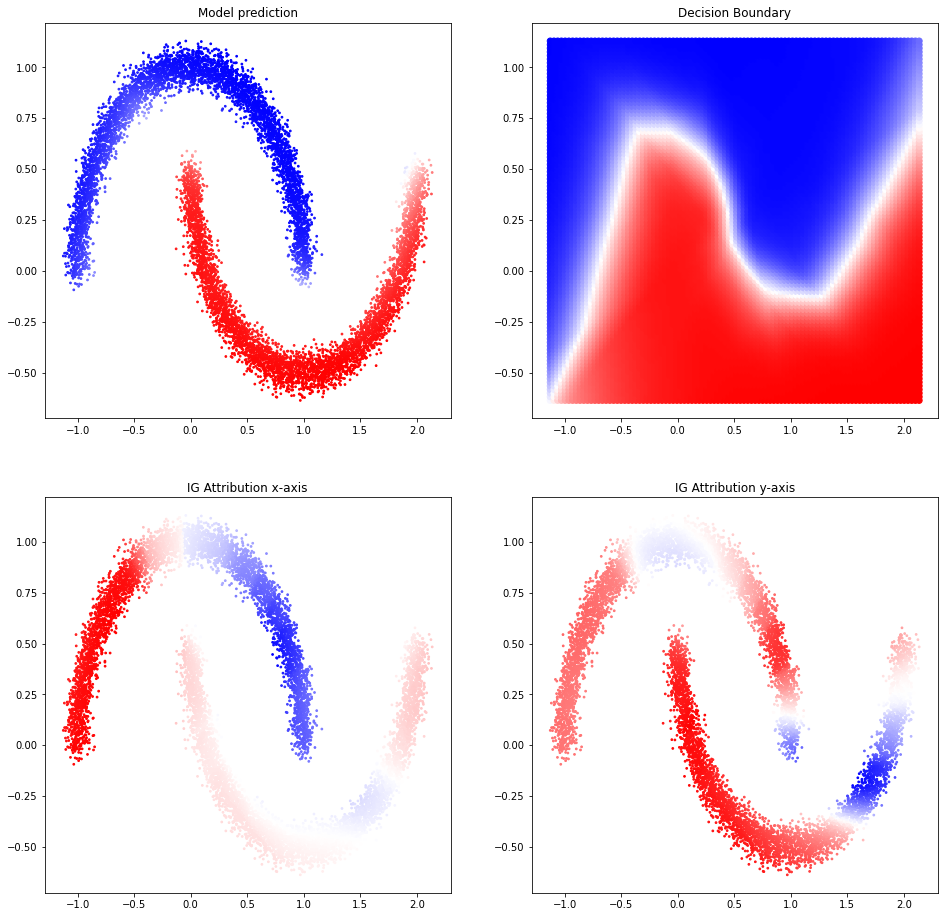

In [7]:
plt.figure(figsize = (16, 16))
R = clf(X)
W = clf(Z)
plt.subplot(221)
plt.scatter(
    X[:, 0],
    X[:, 1],
    c = R,
    s = 3,
    cmap = 'bwr'
)
plt.title('Model prediction')
plt.subplot(222)
plt.scatter(
    Z[:, 0],
    Z[:, 1],
    c = W,
    cmap = 'bwr'
)
plt.title('Decision Boundary')
plt.subplot(223)
plt.scatter(
    X[:, 0],
    X[:, 1],
    c = igx[:, 0],
    s = 3,
    cmap = 'bwr'
)
plt.title('IG Attribution x-axis')
plt.subplot(224)
plt.scatter(
    X[:, 0],
    X[:, 1],
    c = igx[:, 1],
    s = 3,
    cmap = 'bwr'
)
plt.title('IG Attribution y-axis')
plt.show()

In [8]:
X, Y = make_classification(
    n_samples     = 10000,
    n_features    = 20,
    n_informative = 5,
    n_redundant   = 5,
    n_classes     = 2,
    shuffle       = False
)

clf = tfk.Sequential([
    tfkl.InputLayer(X.shape[1]),
    tfkl.Dense(20),
    tfkl.BatchNormalization(),
    tfkl.Lambda(tf.nn.relu),
    tfkl.Dense(1, activation = 'sigmoid')
])
clf.compile(
    loss = 'binary_crossentropy',
    metrics = [tfk.metrics.AUC()],
    optimizer = 'adam'
)
hist = clf.fit(
    X, Y,
    epochs = 10,
    batch_size = 256,
    validation_split = 0.33
)
res = clf.evaluate(X, Y)

Epoch 1/10
27/27 [==============================] - 1s 8ms/step - loss: 0.8568 - auc_1: 0.4496 - val_loss: 0.4221 - val_auc_1: 0.8596
Epoch 2/10
27/27 [==============================] - 0s 3ms/step - loss: 0.6480 - auc_1: 0.7357 - val_loss: 0.4092 - val_auc_1: 0.8852
Epoch 3/10
27/27 [==============================] - 0s 3ms/step - loss: 0.5255 - auc_1: 0.8553 - val_loss: 0.4374 - val_auc_1: 0.8720
Epoch 4/10
27/27 [==============================] - 0s 3ms/step - loss: 0.4498 - auc_1: 0.9016 - val_loss: 0.4933 - val_auc_1: 0.8480
Epoch 5/10
27/27 [==============================] - 0s 3ms/step - loss: 0.3947 - auc_1: 0.9294 - val_loss: 0.5699 - val_auc_1: 0.8224
Epoch 6/10
27/27 [==============================] - 0s 3ms/step - loss: 0.3502 - auc_1: 0.9486 - val_loss: 0.6645 - val_auc_1: 0.7928
Epoch 7/10
27/27 [==============================] - 0s 3ms/step - loss: 0.3130 - auc_1: 0.9625 - val_loss: 0.7402 - val_auc_1: 0.7709
Epoch 8/10
27/27 [==============================] - 0s 3ms/ste

In [9]:
igx = tf.stack([
    IG_1d_clf(x, clf, steps = 64)
    for x in X
])

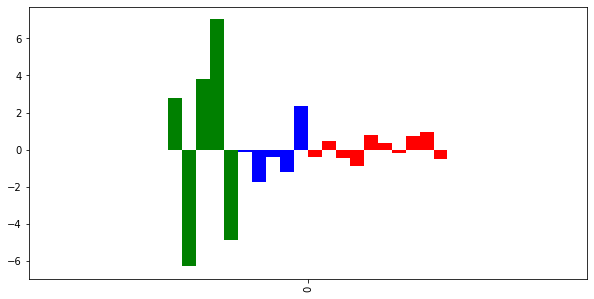

In [10]:
pd.DataFrame(tf.reduce_mean(igx, 0).numpy()).T.plot.bar(
    figsize = (10, 5),
    legend = False,
    color = [
        *( 5 * ['g']),
        *( 5 * ['b']),
        *(10 * ['r'])
    ]
)
plt.show()

In [11]:
%%time

x         = X[1]
fps_base  = 2
dims      = tf.shape(x)[-1]

indices  = tf.range(dims)
stepped  = tf.zeros_like(x)
baseline = tf.zeros_like(x)
grads    = tf.zeros_like(x)
steps  = 32
fps    = fps_base
delta  = (x - baseline) / steps

inputs = baseline

# Loop body
while tf.reduce_any(stepped < steps):
    
    # There is a bug that occurs if a single dimension "remains"
    # That is, all steps have been taken along each dimension except one
    # Then we will still take additional steps along some dimension (a bug)
    # This fixes that
    fps = tf.reduce_min([
        fps_base,
        tf.reduce_sum(
            tf.cast(
                stepped < steps,
                tf.int32
            )
        )
    ])
    
    # Compute gradient
    with tf.GradientTape() as tape:
        tape.watch(inputs)
        res = clf (inputs[tf.newaxis])
    grad = tape.gradient(res, inputs)

    # Find indices of lowest absolute gradients
    # If sufficient steps have already been taken in dimension-direction,
    #   set those gradients to maximum
    grad = tf.where(
        stepped < steps,
        grad,
        tf.reduce_max(tf.abs(grad)) + 1
    )
    lowest = tf.argsort(tf.abs(grad))[:fps]

    # Construct masking vector from (remaining) indices vs minimum gradient
    step_towards = tf.reduce_any(lowest[:, tf.newaxis] == indices[tf.newaxis], 0)

    # Will simply be added to "stepped" (per-dim counter)
    mask_step = tf.cast(
        step_towards,
        stepped.dtype
    )

    # Will be added to cumulative input
    mask_input = tf.cast(
        step_towards, 
        x.dtype
    ) * delta

    # Increment various
    stepped = stepped + mask_step
    inputs  = inputs  + mask_input
    grads   = grads   + grad

CPU times: user 1.57 s, sys: 0 ns, total: 1.57 s
Wall time: 1.5 s


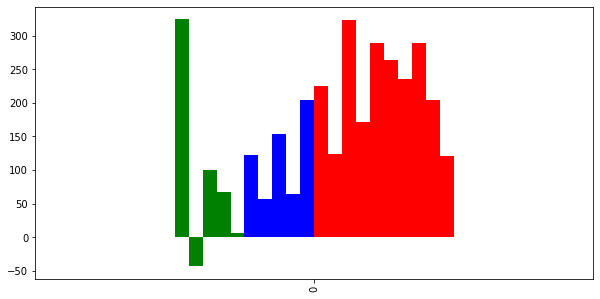

In [12]:
pd.DataFrame(grads.numpy()).T.plot.bar(
    figsize = (10, 5),
    legend = False,
    color = [
        *( 5 * ['g']),
        *( 5 * ['b']),
        *(10 * ['r'])
    ]
)
plt.show()